In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.modeling.models import BlackBody

from pypika import Table
from pypika.dialects import MSSQLQuery

from astroquery.gaia import Gaia

from specutils import Spectrum1D
import speclite.filters
from scipy.optimize import curve_fit, Bounds

pd.set_option('display.max_columns', None)

In [2]:
src = Table("gaiadr3.gaia_source")
ap = Table("gaiadr3.astrophysical_parameters")


q = MSSQLQuery \
    .from_(src) \
    .join(ap) \
    .on(src.source_id == ap.source_id)  \
    .select(src.source_id, src.ra, src.dec, src.parallax , src.radial_velocity,
           src.phot_g_mean_mag, src.phot_bp_mean_mag, src.phot_rp_mean_mag,
           ap.distance_gspphot, ap.teff_gspphot, ap.radius_gspphot, ap.logg_gspphot, ap.mh_gspphot) \
    .top(20) \
    .where(ap.distance_gspphot <= 500) \
    .where(src.ruwe <1.4) \
    .where(src.parallax_over_error >10) \
    .where(src.has_xp_sampled == 'True')

query_sql = q.get_sql().replace('"', '').replace('(', '').replace(')', '')
print(query_sql)

SELECT TOP 20 gaiadr3.gaia_source.source_id,gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec,gaiadr3.gaia_source.parallax,gaiadr3.gaia_source.radial_velocity,gaiadr3.gaia_source.phot_g_mean_mag,gaiadr3.gaia_source.phot_bp_mean_mag,gaiadr3.gaia_source.phot_rp_mean_mag,gaiadr3.astrophysical_parameters.distance_gspphot,gaiadr3.astrophysical_parameters.teff_gspphot,gaiadr3.astrophysical_parameters.radius_gspphot,gaiadr3.astrophysical_parameters.logg_gspphot,gaiadr3.astrophysical_parameters.mh_gspphot FROM gaiadr3.gaia_source JOIN gaiadr3.astrophysical_parameters ON gaiadr3.gaia_source.source_id=gaiadr3.astrophysical_parameters.source_id WHERE gaiadr3.astrophysical_parameters.distance_gspphot<=500 AND gaiadr3.gaia_source.ruwe<1.4 AND gaiadr3.gaia_source.parallax_over_error>10 AND gaiadr3.gaia_source.has_xp_sampled='True'


In [3]:
job     = Gaia.launch_job_async(query_sql)
results = job.get_results()
df = results.to_pandas()
df['source_id'] = df['source_id'].astype(str)
df= df.dropna().reset_index(drop=True)
df.head(20)

INFO: Query finished. [astroquery.utils.tap.core]


,source_id,ra,dec,parallax,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,distance_gspphot,teff_gspphot,radius_gspphot,logg_gspphot,mh_gspphot
0,5937081388118320256,251.623929,-51.624328,2.029256,-28.915335,13.948680,14.438930,13.287662,448.400085,5688.343262,0.8769,4.4441,-0.4156
1,5937144678762395392,251.507664,-50.732406,2.103157,-6.666442,14.693251,15.358689,13.893653,488.259888,4728.604004,1.0288,4.3255,-0.7524
2,5937145400316859392,251.576827,-50.729360,1.961544,-48.503822,13.836512,14.331964,13.173574,483.449890,5802.295898,0.9716,4.3700,-0.3983
3,5937082487630035328,251.537505,-51.571364,1.935506,-23.061106,13.772332,14.242623,13.135678,464.119690,5672.156250,0.9417,4.4013,-0.2595
4,5937174502998274560,250.052855,-51.653262,3.347763,-15.943898,12.659255,13.077198,12.071200,297.728912,5197.052734,1.0165,4.3555,-0.9754
5,5937146156231203072,251.589977,-50.638635,13.398257,12.315269,13.470652,14.585335,12.419784,75.093597,3730.103027,0.5002,4.7313,-0.2001
6,5937146224950656768,251.526358,-50.693475,2.270509,13.199575,12.870523,13.396200,12.183488,435.659790,5685.664551,1.4705,4.0466,-0.3049
7,5937174984034667648,249.978038,-51.652290,2.331942,8.831958,14.986495,15.621740,14.203259,432.745300,4712.182129,0.7672,4.5040,-0.7207
8,5937146499828607488,251.492129,-50.672235,1.967054,7.786420,13.716318,14.186212,13.071121,452.365997,5923.576172,0.9398,4.3808,-0.6338
9,5937083312263918976,251.502533,-51.497934,3.416448,49.739124,14.801149,15.560833,13.951894,283.045288,4465.223633,0.6449,4.6180,-0.2610


In [4]:
# Select a Star
index = 0#df['distance_gspphot'].idxmin()
ra = df.loc[index, 'ra']
dec = df.loc[index, 'dec']
source_id = df.loc[index, 'source_id']
temp_eff = df.loc[index, 'teff_gspphot'] * u.K
phot_g_mean_mag = df.loc[index, 'phot_g_mean_mag']
phot_bp_mean_mag = df.loc[index, 'phot_bp_mean_mag']
phot_rp_mean_mag = df.loc[index, 'phot_rp_mean_mag']

print("RA: {}".format(ra))
print("dec: {}".format(dec))
print("temp_eff: {}".format(temp_eff))

RA: 251.62392868705166
dec: -51.62432760832084
temp_eff: 5688.34326171875 K


In [5]:
# Obtain the spectrum.
datalink = Gaia.load_data(source_id, data_structure = 'INDIVIDUAL', retrieval_type = 'XP_SAMPLED')
outputs = [datalink[key][0] for key in datalink.keys()]
table = outputs[0].to_table()
df_star_spectra = table.to_pandas()

# GAIA Units: Wavelength - nm; flux - W m-2 nm-1
# source
wavelength = (df_star_spectra['wavelength'].to_numpy()*u.nm)
flux = df_star_spectra['flux'].to_numpy()*u.W/u.m**2/u.nm

# Speclite code plays nicer with Angstroms and Erg S-1 cm-2 AA-1
flux_units = u.erg/u.s/u.cm**2/u.AA

wavelength = wavelength.to(u.AA)
flux = flux.to(flux_units)


In [6]:
# Find a Blackbody curve to approximate the spectrum.

# First define the planck function given temperature and wavelength
def planck_wavelength(wavelength, temperature, scale=1):
    wavelength = wavelength.to(u.m)
    numerator = 2*const.h*const.c**2/wavelength**5
    exponent = const.h*const.c/(wavelength*const.k_B*temperature)
    denominator = np.exp(exponent.value)-1
    
    return scale * (numerator/denominator).to(flux_units)

# Second define the curve fit function (adds units on input, removes on output)
def planck_wavelength_curvefit(wavelength, temperature, scale):
    wavelength *= u.AA
    temperature *= u.K
    return planck_wavelength(wavelength, temperature, scale).value

# Third define initial guess and bounds for temperature and scale
temp_guess = temp_eff.value if (temp_eff>0) else 5000
initial_guess = [temp_guess, 1e-17]  

# ideally should set lower bound of temp to be a low positive number, but this
# appears to shift the results in some cases.  Need to research.
bounds=((-np.inf, -np.inf), (np.inf, np.inf))

# Last perform the curve fit
# Fit the blackbody function to the observed data
params_opt, params_cov = curve_fit(planck_wavelength_curvefit, wavelength, flux, p0=initial_guess, bounds=bounds)

fitted_temperature, fitted_scale = params_opt
fitted_temperature *= u.K
print("Fitted Temperature:", fitted_temperature)
print("Fitted Amplitude:", fitted_scale)

flux_fitted = planck_wavelength(wavelength, fitted_temperature, fitted_scale)


# Alternate with Astropy BlackBody model
def blackbody_function (wavelength, temp, scale):
    wavelength = wavelength * u.AA
    bb = BlackBody(temperature=temp*u.K, scale=scale*flux_units/u.sr)
    return bb(wavelength).value

params_opt, params_cov = curve_fit(blackbody_function, wavelength, flux, p0=initial_guess, bounds=bounds)

bb_fitted_temperature, bb_fitted_scale = params_opt
bb_fitted_temperature *= u.K
print("Fitted Temperature:", bb_fitted_temperature)
print("Fitted Amplitude:", bb_fitted_scale)

bb = BlackBody(temperature=bb_fitted_temperature, scale=bb_fitted_scale*flux_units/u.sr)
bb_flux_fitted = bb(wavelength)


Fitted Temperature: 4815.428084132471 K
Fitted Amplitude: 7.173858612294208e-21
Fitted Temperature: 4815.428083660785 K
Fitted Amplitude: 7.173858615706978e-21


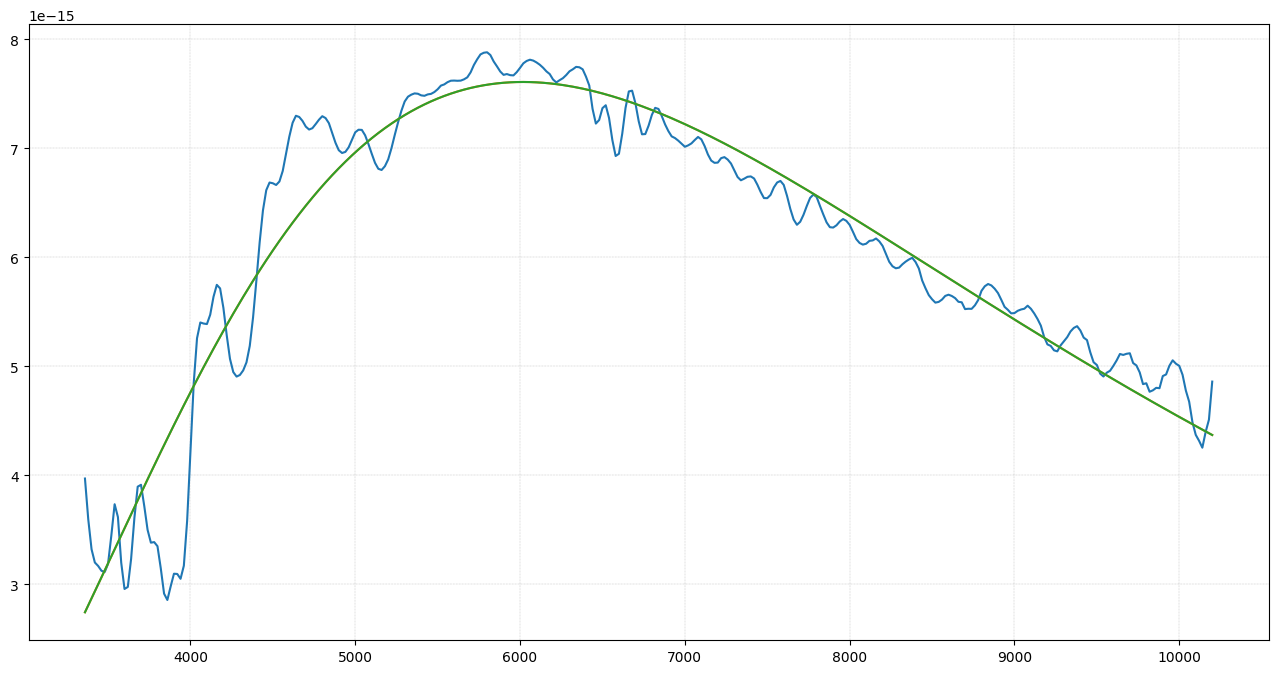

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.grid(color='grey', alpha=0.8, linestyle='-.', linewidth=0.2, axis='both') 
ax.plot(wavelength, flux)
ax.plot(wavelength, flux_fitted)
ax.plot(wavelength, bb_flux_fitted)


G: delta extended:-0.10321543285667545, delta fitted:-0.10333342600993944
BP: delta extended:-0.04448052720979412, delta fitted:-0.06256701551831334
RP: delta extended:-0.3587533850081197, delta fitted:-0.34582817722722226


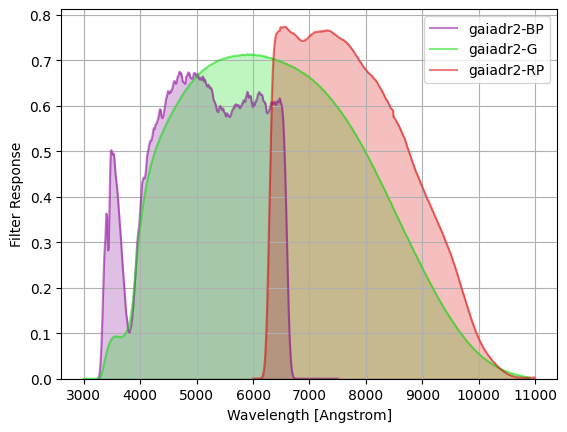

In [8]:
# Try computing apparent magnitudes with speclite filters and compare against GAIA values.
gaiadr2 = speclite.filters.load_filters('gaiadr2-*')
flux_extended, wavelength_extended = gaiadr2.pad_spectrum(flux, wavelength)
flux_fitted_extended = planck_wavelength(wavelength_extended, fitted_temperature, fitted_scale)

ab_magnitudes = gaiadr2.get_ab_magnitudes(flux_extended, wavelength_extended)
fitted_ab_magnitudes = gaiadr2.get_ab_magnitudes(flux_fitted_extended, wavelength_extended)

apparent_magnitude_g = ab_magnitudes['gaiadr2-G'][0]
apparent_magnitude_bp = ab_magnitudes['gaiadr2-BP'][0]
apparent_magnitude_rp = ab_magnitudes['gaiadr2-RP'][0]

fitted_apparent_magnitude_g = fitted_ab_magnitudes['gaiadr2-G'][0]
fitted_apparent_magnitude_bp = fitted_ab_magnitudes['gaiadr2-BP'][0]
fitted_apparent_magnitude_rp = fitted_ab_magnitudes['gaiadr2-RP'][0]

print("G: delta extended:{}, delta fitted:{}".format(phot_g_mean_mag-apparent_magnitude_g, phot_g_mean_mag-fitted_apparent_magnitude_g))
print("BP: delta extended:{}, delta fitted:{}".format(phot_bp_mean_mag-apparent_magnitude_bp, phot_bp_mean_mag-fitted_apparent_magnitude_bp))
print("RP: delta extended:{}, delta fitted:{}".format(phot_rp_mean_mag-apparent_magnitude_rp, phot_rp_mean_mag-fitted_apparent_magnitude_rp))

speclite.filters.plot_filters(gaiadr2)

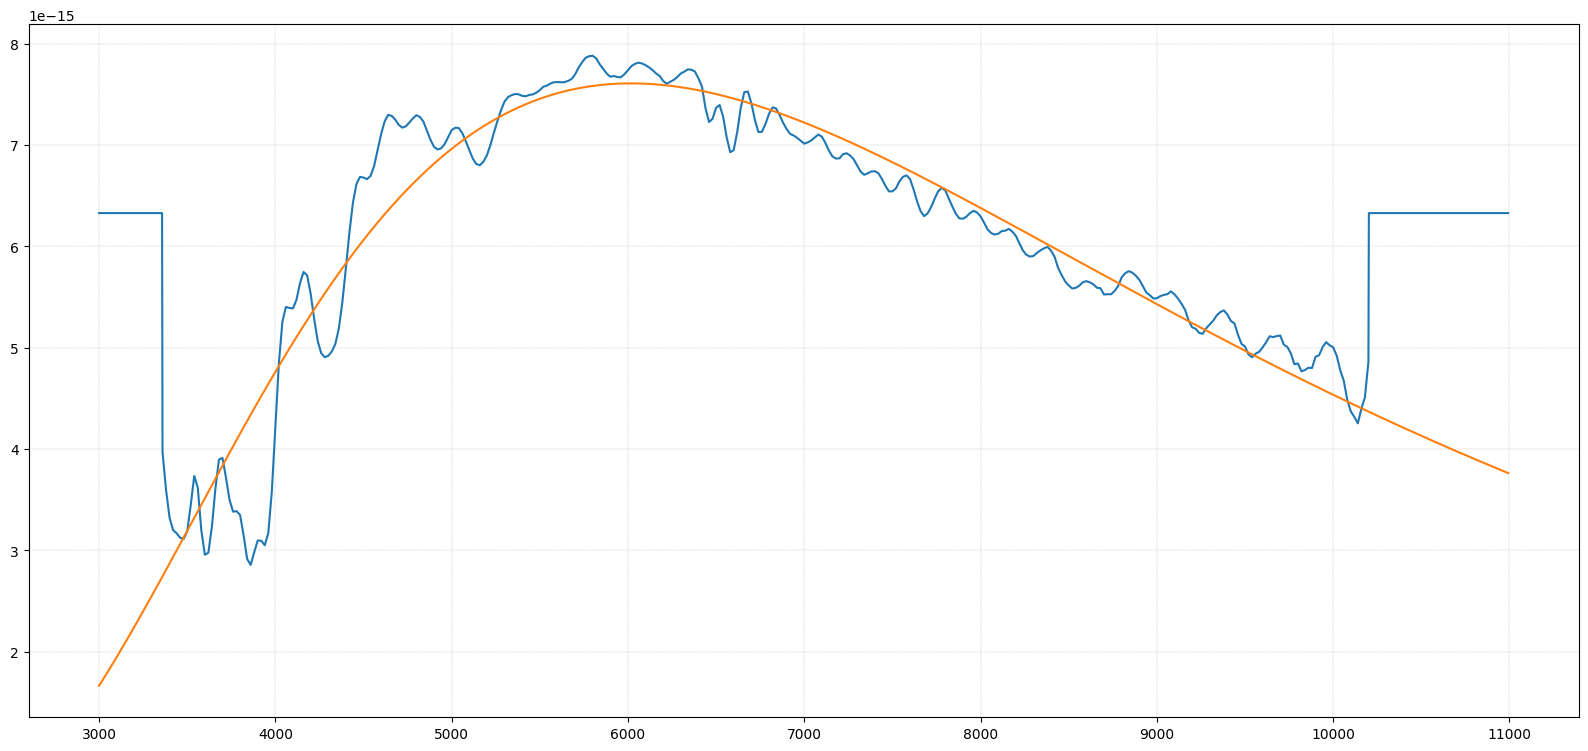

In [9]:
fig, ax = plt.subplots(figsize=(20, 9))
ax.grid(color='grey', alpha=0.8, linestyle='-.', linewidth=0.2, axis='both') 
ax.plot(wavelength_extended, flux_extended)
ax.plot(wavelength_extended, flux_fitted_extended)

In [ ]:
#dist_max = 1000
#temp_min = 2000
#temp_max = 10000

#query = f"SELECT TOP 100 * FROM gaiadr3.gaia_source \
#    JOIN gaiadr3.astrophysical_parameters AS ap USING (source_id) \
#    WHERE ap.distance_gspphot <= {dist_max} AND \
#    ap.teff_gspphot >= {temp_min} AND ap.teff_gspphot <= {temp_max} AND \
#    ruwe <1.4 AND parallax_over_error >10 AND has_xp_sampled = 'True'"

#job     = Gaia.launch_job_async(query)
#results = job.get_results()
#df_full = results.to_pandas()
df = df_full[['source_id', 'ra', 'dec', 'parallax', 'distance_gspphot', 'teff_gspphot', 'radius_gspphot', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'radial_velocity', 'logg_gspphot', 'mh_gspphot', ]].copy()
df['source_id'] = df['source_id'].astype(str)
df= df.dropna().reset_index(drop=True)
df.head(20)